In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import datetime
from libs.sequences import SeismicSequence
from libs.iris import irisRequests
from libs.distributions import Weibull, WeibullMM, GaussianMM, InterTimeDistribution
from importlib import reload  # Python 3.4+
import matplotlib.pyplot as plt
from ntpp_utils import get_time_nll_loss

In [3]:
def load_hauksson():
    column_names = ["year","month","day", "hour", "minut", 'sec', "id",
                    "lat","lon", "depth", "mag", "nPhases", "azGap", "nearDist", "hErr", "vErr", "residual", "flag1", "flag2"]
    df = pd.read_csv("catalogs/sc_1981_2022q1_1d_3d_gc_soda.gc", sep="\s+", usecols=range(0,11), header=None,names=column_names[:11])
    df['time'] = pd.to_datetime(dict(year=df.year, month=df.month, day=df.day, hours=df.hour, minutes=df.minut, seconds=df.sec))
    return df

# Model

In [4]:
class GRUPointProcess(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_mixtures=1):
        super().__init__()
        self.rnn = nn.GRU(input_dim,hidden_dim,
                          num_layers=1,
                          batch_first=True)
        self.n_mixtures = n_mixtures
        if(self.n_mixtures==1):
            self.weibull_mod = nn.Sequential(
                nn.Linear(hidden_dim, 2),
                nn.Softplus()
            )
        else:
            self.weibull_mod = nn.Sequential(
                nn.Linear(hidden_dim, self.n_mixtures*2),
                nn.Softplus()
            )
            self.mixture_mod = nn.Sequential(
                nn.Linear(hidden_dim, self.n_mixtures),
                nn.Softmax(dim=-1)
            )
    def forward(self,x):
        rnn_output, _ = self.rnn(x) # (n_sequences ~ batch size, max_seq_length, hidden_dim )
        # shift forward along the time dimension and pad
        # so we can use it to model the inter times
        context = F.pad(rnn_output[:, :-1, :], (0,0, 1,0))
        weibull_params = self.weibull_mod(context)
        if(self.n_mixtures == 1):
            distr = Weibull(weibull_params[..., 0], weibull_params[..., 1])
        else:
            pip_params = self.mixture_mod(context)
            distr = WeibullMM(pip_params, weibull_params[..., :self.n_mixtures], weibull_params[..., self.n_mixtures:])
        return context, distr

# Data

In [5]:
region_limits = [29.0, 37.0, -123.0, -112.0 ]
df = load_hauksson()
df.head(5)

,year,month,day,hour,minut,sec,id,lat,lon,depth,mag,time
0,1981,1,1,1,49,29.357,3301561,33.73166,-118.81097,6.399,2.27,1981-01-01 01:49:29.357
1,1981,1,1,4,13,55.936,3301565,33.25355,-115.96716,6.347,2.26,1981-01-01 04:13:55.936
2,1981,1,1,5,20,14.634,3301566,34.18175,-117.30450,5.864,2.37,1981-01-01 05:20:14.634
3,1981,1,1,5,39,56.616,3301567,34.18031,-117.30303,5.991,1.60,1981-01-01 05:39:56.616
4,1981,1,1,8,23,18.236,3301570,34.00782,-117.16284,15.468,1.88,1981-01-01 08:23:18.236


In [6]:
end_date_train = datetime.datetime(2009, 1, 1, 0, 0, 0)
start_date_test = datetime.datetime(2011, 1, 1, 0, 0, 0)
train_sequences = SeismicSequence.from_pandas_df(df[df.time < end_date_train ],
                                                 time_label='time',
                                                 other_labels=['lat','lon', 'mag'],
                                                 unit='D')
test_sequences = SeismicSequence.from_pandas_df(df[df.time >= start_date_test ],
                                                 time_label='time',
                                                 other_labels=['lat','lon', 'mag'],
                                                 unit='D')
val_sequences = SeismicSequence.from_pandas_df(df[(df.time < start_date_test)*(df.time >= end_date_train) ],
                                                 time_label='time',
                                                 other_labels=['lat','lon', 'mag'],
                                                 unit='D')

# Training

In [10]:
model = GRUPointProcess(2, 10, n_mixtures=1)

In [11]:
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [12]:
epochs = 100
use_random_length = True
duration = 5
loss_hist = []
inter_times = None
for epoch in range(epochs):
    print(epoch)
    with torch.no_grad():
        seqs = []
        t_start = duration
        max_t_end = train_sequences.t_end
        sequences_durations = []
        while(True):
            if(use_random_length):
                t_end = t_start + np.random.exponential()*duration
            else:
                t_end = t_start + duration
            if(t_end > max_t_end):
                break
            sub_seq = train_sequences.get_subsequence(t_start, t_end)
            if(len(sub_seq.arrival_times) > 0):
                seqs.append(sub_seq)
                sequences_durations.append(t_end - t_start)
            t_start = t_end
        sequences_durations = torch.Tensor(sequences_durations)
        inter_times, features, lengths = SeismicSequence.pack_sequences(seqs) 
    optimizer.zero_grad()
    input_time_features = torch.cat([inter_times.unsqueeze(-1), inter_times.clamp_min(1e-8).log().unsqueeze(-1)], dim=-1)
    context, distr = model(input_time_features)
    loss = (get_time_nll_loss(inter_times, lengths, distr)/sequences_durations).mean()
    loss.backward()
    optimizer.step()
    print(loss.item())
    loss_hist.append(loss.item())

0
-57.0944709777832
1
-59.346710205078125
2
-60.545040130615234
3
-56.286251068115234
4
-63.39284896850586
5
-66.67843627929688
6
-65.4322280883789
7


KeyboardInterrupt: 

In [247]:
with torch.no_grad():
    n_seeds = 10
    n_predictions = 100
    base_inter_times = val_sequences.inter_times[:n_seeds]
    using_inter_times = base_inter_times
    predicted_inter_times = []
    for step in range(n_predictions):
        input_time_features = torch.cat([using_inter_times[None,:,None], using_inter_times[None,:,None].clamp_min(1e-8).log()], dim=-1)
        context, distr = model(input_time_features)
        next_inter_time_b = distr.b[0,-1]
        next_inter_time_k = distr.k[0,-1]
        next_inter_time = (-np.log(1-np.random.uniform(0,1))/next_inter_time_b)**(1/next_inter_time_k)
        predicted_inter_times.append(next_inter_time)
        using_inter_times = torch.cat([using_inter_times,torch.tensor([next_inter_time]) ]).type(torch.float32)

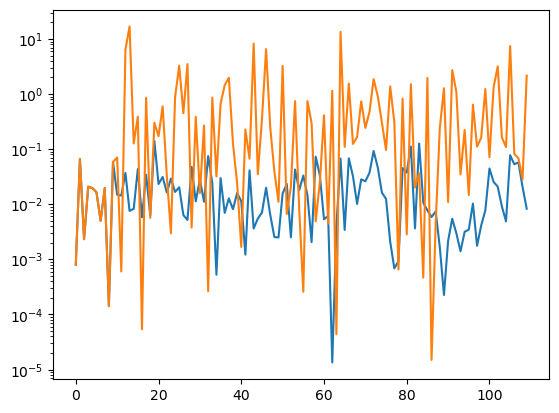

In [249]:
plt.plot(val_sequences.inter_times[:n_seeds+n_predictions])
plt.plot(using_inter_times)
plt.yscale('log')